---
we'll use tensorflow to predict the number of shapes in each image -- first let's get the pixel data, saving it as `.npy` files in `greyscale-data`

---

In [32]:
import os
import numpy as np
import png


input_directory = 'greyscale-images'
output_directory = 'greyscale-data'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

for filename in os.listdir(input_directory):
  path = os.path.join(input_directory, filename)
  with open(path, 'rb') as image_file:
    reader = png.Reader(file=image_file)
    _, _, pixels, _ = reader.asDirect()
    data = np.array([x / 255. for row in pixels for x in row])
  output_filename = '%s.npy' % filename.split('.')[0]
  output_path = os.path.join(output_directory, output_filename)
  np.save(output_path, data)

---
load data

---

In [37]:
import os
import numpy as np

input_directory = 'greyscale-data'

# Load all the data into an array.
# Each element is a tuple: (filename, numpy data).
# The filename structure is "<number>-<color>-<texture>-<shape>-<rotation>.png"
data = [
  (f, np.load(os.path.join(input_directory, f))) for f in os.listdir(input_directory)
]

In [40]:
import random
import tensorflow as tf


input_directory = 'greyscale-data'
card_width, card_height = 150, 150

x = tf.placeholder(tf.float32, shape=[None, card_width*card_height])
W = tf.Variable(tf.zeros([card_width*card_height, 3]))
b = tf.Variable(tf.zeros([3]))
y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 3])

cross_entropy = -tf.reduce_sum(y_ * tf.log(y))
train_step = tf.train.GradientDescentOptimizer(0.000001).minimize(cross_entropy)

session = tf.Session()
session.run(tf.initialize_all_variables())

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

kinds = [
    [1.0, 0.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.0, 0.0, 1.0],
]

all_xs = [image_data for _, image_data in data]
all_ys = [kinds[int(f.split('-')[0]) - 1] for f, _ in data]

accuracies = []
steps = 10000
for i in range(steps):
  batch = random.sample(data, 10)
  batch_xs = [image_data for _, image_data in batch]
  batch_ys = [kinds[int(f.split('-')[0]) - 1] for f, _ in batch]
  session.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
  if (i % 50) == 0:
    a = session.run(accuracy, feed_dict={x: all_xs, y_: all_ys})
    accuracies.append(a)
    if (i % 500) == 0:
      print 'iteration: %s -> accuracy: %s' % (i, a)

print 'done.'

iteration: 0 -> accuracy: 0.333333
iteration: 500 -> accuracy: 0.546296
iteration: 1000 -> accuracy: 0.746914
iteration: 1500 -> accuracy: 0.700617
iteration: 2000 -> accuracy: 0.58642
iteration: 2500 -> accuracy: 0.734568
iteration: 3000 -> accuracy: 0.679012
iteration: 3500 -> accuracy: 0.580247
iteration: 4000 -> accuracy: 0.959877
iteration: 4500 -> accuracy: 0.990741
iteration: 5000 -> accuracy: 1.0
iteration: 5500 -> accuracy: 0.916667
iteration: 6000 -> accuracy: 0.981481
iteration: 6500 -> accuracy: 0.919753
iteration: 7000 -> accuracy: 0.984568
iteration: 7500 -> accuracy: 0.979938
iteration: 8000 -> accuracy: 1.0
iteration: 8500 -> accuracy: 1.0
iteration: 9000 -> accuracy: 1.0
iteration: 9500 -> accuracy: 1.0
done.


---
plot the accuracy vs iteration number

---

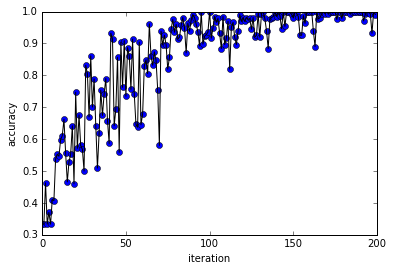

In [41]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.plot(accuracies, 'bo')
plt.plot(accuracies, 'k-')
_ = plt.xlabel('iteration')
_ = plt.ylabel('accuracy')